In [1]:
import gdown
import zipfile
import os
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T
import torch.nn.functional as F
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, DDIMScheduler, DDIMInverseScheduler
from diffusers.models.attention_processor import AttnProcessor
from PIL import Image
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as T
import torch.nn.functional as F
from transformers import pipeline

2025-04-17 18:21:52.015103: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744914112.037853     104 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744914112.044765     104 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
pip install controlnet_aux

Note: you may need to restart the kernel to use updated packages.


In [3]:
file_id = "1Yu3MQJ4v7k_vYEQ12QtfP_nxPgY7S-jF"  
url = f"https://drive.google.com/uc?id={file_id}"

output = "downloaded_folder.zip"
gdown.download(url, output, quiet=False)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("unzipped_folder") 

Downloading...
From (original): https://drive.google.com/uc?id=1Yu3MQJ4v7k_vYEQ12QtfP_nxPgY7S-jF
From (redirected): https://drive.google.com/uc?id=1Yu3MQJ4v7k_vYEQ12QtfP_nxPgY7S-jF&confirm=t&uuid=c9055552-9563-48fc-a66e-e162e2ab97a4
To: /kaggle/working/downloaded_folder.zip
100%|██████████| 47.8M/47.8M [00:00<00:00, 212MB/s]


In [4]:
base_path = "/kaggle/working/unzipped_folder/bear/images_4"
images = os.listdir(base_path)

In [5]:
len(images)

96

In [6]:
ref_img_idx = np.random.randint(1,97,4)
ref_img_idx

array([83, 42, 34, 51])

In [7]:
img_paths = []
for img_path in images:
    img_paths.append(os.path.join(base_path, img_path))

In [8]:
ref_img_paths = [img_paths[idx] for idx in ref_img_idx]

In [9]:
def load_preprocess_img(img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((512,512))
    img = np.array(img).astype(np.float32) / 255.0
    img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).to("cuda").to(torch.float16)

    return img

In [10]:
img_tbe = load_preprocess_img(img_paths[0])

In [11]:
ref_img = [load_preprocess_img(img_path) for img_path in ref_img_paths]

In [12]:
from controlnet_aux import MidasDetector

/usr/local/lib/python3.11/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [13]:
# def img2depth(img_path):
#     raw_img = Image.open(img_path)
#     raw_img = raw_img.resize((512,512))
#     depth_detector = MidasDetector.from_pretrained("lllyasviel/ControlNet")
#     depth_map = depth_detector(raw_img)

#     return depth_map

In [25]:
def img2depth(img_path):
    raw_img = Image.open(img_path)
    raw_img = raw_img.resize((512,512))
    pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Large-hf")
    depth = pipe(raw_img)["depth"]

    return depth

In [26]:
ref_img_depth = [img2depth(img) for img in ref_img_paths]

Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


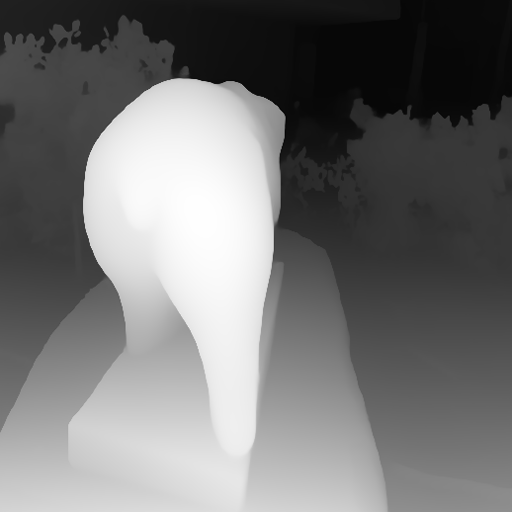

In [27]:
ref_img_depth[0]

In [19]:
ref_img_depth[0].size

NameError: name 'ref_img_depth' is not defined

In [17]:
depth_map = img2depth(img_paths[0])

In [18]:
depth_map.size

(512, 512)

In [35]:
# def load_and_preprocess_depth_map(depth_image=None, image_path="depth_map.png", target_size=512):

#     # print(type(depth_image))
#     # print(depth_image.size)
#     if depth_image is None:
#         # Load depth map (8-bit or 16-bit grayscale image)
#         depth_image = Image.open(image_path).convert("L")  # Convert to grayscale

#     # Convert to float tensor
#     depth_tensor = T.ToTensor()(depth_image).float()  # Shape: [1, H, W]
#     # Expand to shape [1, 1, H, W]
#     depth_tensor = depth_tensor.unsqueeze(0)  # Shape: [1, 1, H, W]

#     # Convert to disparity
#     epsilon = 1e-6
#     disparity = 1.0 / (depth_tensor + epsilon)

#     # Normalize disparity to [0, 1]
#     disparity -= disparity.min()
#     disparity /= (disparity.max() + 1e-8)

#     # print(disparity.size())
#     # Resize to target model input (e.g., 512x512)
#     disparity = F.interpolate(disparity, size=(target_size, target_size), mode='bilinear', align_corners=False)

#     # print(disparity.size())
#     # Repeat to 3 channels for model
#     # disparity = disparity.repeat(1, 3, 1, 1)  # Shape: [1, 3, H, W]

#     return disparity


In [50]:
def load_and_preprocess_depth_map(image: Image.Image):
    # Convert to grayscale and to numpy array
    gray = image.convert("L")  # Convert to grayscale
    img_np = np.array(gray).astype(np.float32)  # shape: (H, W)

    # Normalize values to (0, 1)
    img_np = img_np / 255.0 + 1e-5

    # Inverse for disparity-like representation
    disparity = 1.0 / img_np
    disparity_map = disparity / np.max(disparity)  # Normalize to (0, 1)

    # Stack to 3 channels
    disparity_map = np.stack([disparity_map]*3, axis=0)  # shape: (3, H, W)

    return torch.tensor(disparity_map[None])  # Add batch dimension -> shape: (1, 3, H, W)


In [52]:
disparity = load_and_preprocess_depth_map(depth_map)

In [53]:
disparity.shape

torch.Size([1, 3, 512, 512])

In [54]:
# Load the ControlNet model
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-depth")

# Initialize the Stable Diffusion pipeline with ControlNet
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", controlnet=controlnet
).to("cuda").to(torch.float16)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [55]:
from torchvision.transforms import Resize, InterpolationMode
from einops import rearrange
import glob
from diffusers.utils import USE_PEFT_BACKEND

def read_depth2disparity(depth_dir):
    depth_paths = sorted(glob.glob(depth_dir + '/*.npy'))
    disparity_list = []
    for depth_path in depth_paths:
        depth = np.load(depth_path) # [512,512,1] 
        
        disparity = 1 / (depth + 1e-5)
        disparity_map = disparity / np.max(disparity) # 0.00233~1
        # disparity_map = disparity_map.astype(np.uint8)[:,:,0]
        disparity_map = np.concatenate([disparity_map, disparity_map, disparity_map], axis=2)
        disparity_list.append(disparity_map[None]) 

    detected_maps = np.concatenate(disparity_list, axis=0)
    
    control = torch.from_numpy(detected_maps.copy()).float()
    return rearrange(control, 'f h w c -> f c h w')

def compute_attn(attn, query, key, value, video_length, ref_frame_index, attention_mask):
    key_ref_cross = rearrange(key, "(b f) d c -> b f d c", f=video_length)
    key_ref_cross = key_ref_cross[:, ref_frame_index]
    key_ref_cross = rearrange(key_ref_cross, "b f d c -> (b f) d c")
    value_ref_cross = rearrange(value, "(b f) d c -> b f d c", f=video_length)
    value_ref_cross = value_ref_cross[:, ref_frame_index]
    value_ref_cross = rearrange(value_ref_cross, "b f d c -> (b f) d c")

    key_ref_cross = attn.head_to_batch_dim(key_ref_cross)
    value_ref_cross = attn.head_to_batch_dim(value_ref_cross)
    attention_probs = attn.get_attention_scores(query, key_ref_cross, attention_mask)
    hidden_states_ref_cross = torch.bmm(attention_probs, value_ref_cross) 
    return hidden_states_ref_cross

class CrossViewAttnProcessor:
    def __init__(self, self_attn_coeff, unet_chunk_size=2):
        self.unet_chunk_size = unet_chunk_size
        self.self_attn_coeff = self_attn_coeff

    def __call__(
            self,
            attn,
            hidden_states,
            encoder_hidden_states=None,
            attention_mask=None,
            temb=None,
            scale=1.0,):

        residual = hidden_states
        
        args = () if USE_PEFT_BACKEND else (scale,)

        if attn.spatial_norm is not None:
            hidden_states = attn.spatial_norm(hidden_states, temb)

        input_ndim = hidden_states.ndim

        if input_ndim == 4:
            batch_size, channel, height, width = hidden_states.shape
            hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

        batch_size, sequence_length, _ = (
            hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
        )
        attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)

        if attn.group_norm is not None:
            hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

        query = attn.to_q(hidden_states, *args)

        is_cross_attention = encoder_hidden_states is not None
        if encoder_hidden_states is None:
            encoder_hidden_states = hidden_states
        elif attn.norm_cross:
            encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)

        key = attn.to_k(encoder_hidden_states, *args)
        value = attn.to_v(encoder_hidden_states, *args)
        query = attn.head_to_batch_dim(query)
        # Sparse Attention
        if not is_cross_attention:
            ################## Perform self attention
            key_self = attn.head_to_batch_dim(key)
            value_self = attn.head_to_batch_dim(value)
            attention_probs = attn.get_attention_scores(query, key_self, attention_mask)
            hidden_states_self = torch.bmm(attention_probs, value_self)
            #######################################

            video_length = key.size()[0] // self.unet_chunk_size
            ref0_frame_index = [0] * video_length
            ref1_frame_index = [1] * video_length
            ref2_frame_index = [2] * video_length
            ref3_frame_index = [3] * video_length
            
            hidden_states_ref0 = compute_attn(attn, query, key, value, video_length, ref0_frame_index, attention_mask)
            hidden_states_ref1 = compute_attn(attn, query, key, value, video_length, ref1_frame_index, attention_mask)
            hidden_states_ref2 = compute_attn(attn, query, key, value, video_length, ref2_frame_index, attention_mask)

            key = rearrange(key, "(b f) d c -> b f d c", f=video_length)
            key = key[:, ref3_frame_index]
            key = rearrange(key, "b f d c -> (b f) d c")
            value = rearrange(value, "(b f) d c -> b f d c", f=video_length)
            value = value[:, ref3_frame_index]
            value = rearrange(value, "b f d c -> (b f) d c")

        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value)

        attention_probs = attn.get_attention_scores(query, key, attention_mask)
        hidden_states_ref3 = torch.bmm(attention_probs, value)
        
        hidden_states = self.self_attn_coeff * hidden_states_self + (1 - self.self_attn_coeff) * torch.mean(torch.stack([hidden_states_ref0, hidden_states_ref1, hidden_states_ref2, hidden_states_ref3]), dim=0) if not is_cross_attention else hidden_states_ref3 
        hidden_states = attn.batch_to_head_dim(hidden_states)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states, *args)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        if input_ndim == 4:
            hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

        if attn.residual_connection:
            hidden_states = hidden_states + residual

        hidden_states = hidden_states / attn.rescale_output_factor

        return hidden_states

In [56]:
def img2latent(img):
    pipe.unet.set_attn_processor(processor=AttnProcessor())
    pipe.controlnet.set_attn_processor(processor=AttnProcessor()) 
    
    # Encode the image to latents
    vae = pipe.vae
    latents = vae.encode(img * 2 - 1)["latent_dist"].mean * 0.18215
    
    # Set up the DDIM inversion scheduler
    ddim_inverser = DDIMInverseScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
    pipe.scheduler = ddim_inverser

    # print(latents.shape)
    # print(disparity.shape)
    # Perform DDIM inversion to obtain the initial noise
    init_noise = pipe(prompt="", num_inference_steps=20, latents=latents, image=disparity, return_dict=False ,guidance_scale=0, output_type="latent")[0]

    return init_noise

In [57]:
init_noise = img2latent(img_tbe)

  0%|          | 0/20 [00:00<?, ?it/s]

In [58]:
pipe.unet.set_attn_processor(
                processor=CrossViewAttnProcessor(self_attn_coeff=0.6,
                unet_chunk_size=2))
pipe.controlnet.set_attn_processor(
                processor=CrossViewAttnProcessor(self_attn_coeff=0,
                unet_chunk_size=2)) 

In [59]:
ddim_scheduler = DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
pipe.scheduler = ddim_scheduler

In [60]:
pipe.scheduler = ddim_scheduler
pipe.unet.set_attn_processor(
                processor=CrossViewAttnProcessor(self_attn_coeff=0.6,
                unet_chunk_size=2))
pipe.controlnet.set_attn_processor(
                processor=CrossViewAttnProcessor(self_attn_coeff=0,
                unet_chunk_size=2)) 

In [61]:
ref_z0s_list = [img2latent(img) for img in ref_img]
ref_disparity_list = [load_and_preprocess_depth_map(img) for img in ref_img_depth]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [62]:
ref_z0s = torch.cat(ref_z0s_list, dim=0) 
ref_disparity = torch.cat(ref_disparity_list, dim=0)

In [63]:
z0 = img2latent(img_tbe)
depth = img2depth(img_paths[0])
disparity = load_and_preprocess_depth_map(depth)

  0%|          | 0/20 [00:00<?, ?it/s]

In [64]:
disp_ctrl_chunk = torch.concatenate((ref_disparity, disparity), dim=0)
latents_chunk = torch.concatenate((ref_z0s, z0), dim=0)

In [65]:
disp_ctrl_chunk.shape

torch.Size([5, 3, 512, 512])

In [66]:
disp_ctrl_chunk.shape

torch.Size([5, 3, 512, 512])

In [67]:
latents_chunk.shape

torch.Size([5, 4, 64, 64])

In [68]:
chunk_edited = pipe(
                    prompt=["a grizly bear"]*5,
                    # negative_prompt=[self.negative_prompts] * (self.num_ref_views+len(chunked_data)),
                    latents=latents_chunk,
                    image=disp_ctrl_chunk,
                    num_inference_steps=20,
                    guidance_scale=5,
                    controlnet_conditioning_scale=1.0,
                    # eta=self.eta,
                    output_type='pt',
                ).images
# chunk_edited = chunk_edited.cpu() 

  0%|          | 0/20 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.50 GiB. GPU 0 has a total capacity of 15.89 GiB of which 915.12 MiB is free. Process 12792 has 14.99 GiB memory in use. Of the allocated memory 10.74 GiB is allocated by PyTorch, and 3.96 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
chunk_edited.shape